In [3]:
!pip install xgboost scikit-learn
import os
import re
import numpy as np
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/CSI"

Mounted at /content/drive


In [5]:
def process_csv(filepath):
    df = pd.read_csv(filepath)
    amp = extract_amplitude_features(df)
    if amp.size == 0:
        raise ValueError("Amplitude array is empty")
    feature_vector = np.concatenate([
        amp.mean(axis=0),
        amp.std(axis=0),
        np.max(amp, axis=0),
        np.min(amp, axis=0)
    ])
    return feature_vector


In [6]:
# 복소수 CSI → 진폭 변환 함수
def extract_amplitude_features(df):
    amplitude_matrix = []
    for col in df.columns:
        if re.match(r'^_\d+$', col):  # _0 ~ _63
            cleaned = []
            for val in df[col].dropna():
                try:
                    c = complex(str(val).replace("(", "").replace(")", "").replace(" ", "").replace("nan", "0"))
                    cleaned.append(abs(c))
                except Exception:
                    cleaned.append(np.nan)
            amplitude_matrix.append(np.array(cleaned))
    result = np.array(amplitude_matrix).T if amplitude_matrix else np.array([])
    return result

In [7]:
# 단일 CSV → 통계 기반 벡터
def load_flat_dataset(folder_path):
    X, y = [], []
    label_map = {}
    files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.csv')])
    print(f"CSV 파일 수: {len(files)}")

    for file in files:
        class_name = "_".join(file.split("_")[:3])  # 예: hands_up_bath
        if class_name not in label_map:
            label_map[class_name] = len(label_map)
        label = label_map[class_name]

        file_path = os.path.join(folder_path, file)
        try:
            features = process_csv(file_path)
            X.append(features)
            y.append(label)
            print(f"{file} → 라벨 {label}")
        except Exception as e:
            print(f"❌ 처리 실패: {file} | 에러: {e}")

    return np.array(X), np.array(y), label_map


In [8]:
from sklearn.model_selection import train_test_split

# 데이터 로딩
X, y, label_map = load_flat_dataset("/content/drive/MyDrive/CSI")

# 클래스 이름 정렬
class_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

CSV 파일 수: 80
hands_up_bath_1.csv → 라벨 0
hands_up_bath_10.csv → 라벨 0
hands_up_bath_11.csv → 라벨 0
hands_up_bath_12.csv → 라벨 0
hands_up_bath_13.csv → 라벨 0
hands_up_bath_14.csv → 라벨 0
hands_up_bath_15.csv → 라벨 0
hands_up_bath_16.csv → 라벨 0
hands_up_bath_17.csv → 라벨 0
hands_up_bath_18.csv → 라벨 0
hands_up_bath_19.csv → 라벨 0
hands_up_bath_2.csv → 라벨 0
hands_up_bath_20.csv → 라벨 0
hands_up_bath_3.csv → 라벨 0
hands_up_bath_4.csv → 라벨 0
hands_up_bath_5.csv → 라벨 0
hands_up_bath_6.csv → 라벨 0
hands_up_bath_7.csv → 라벨 0
hands_up_bath_8.csv → 라벨 0
hands_up_bath_9.csv → 라벨 0
hands_up_bed_1.csv → 라벨 1
hands_up_bed_10.csv → 라벨 1
hands_up_bed_11.csv → 라벨 1
hands_up_bed_12.csv → 라벨 1
hands_up_bed_13.csv → 라벨 1
hands_up_bed_14.csv → 라벨 1
hands_up_bed_15.csv → 라벨 1
hands_up_bed_16.csv → 라벨 1
hands_up_bed_17.csv → 라벨 1
hands_up_bed_18.csv → 라벨 1
hands_up_bed_19.csv → 라벨 1
hands_up_bed_2.csv → 라벨 1
hands_up_bed_20.csv → 라벨 1
hands_up_bed_3.csv → 라벨 1
hands_up_bed_4.csv → 라벨 1
hands_up_bed_5.csv → 라벨 1
hands_up_

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# (1) 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# (2) 넘파이 → Torch Tensor 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# (3) DataLoader 생성
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
# MLP 모델 정의
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]      # 256
hidden_dim = 64
output_dim = len(np.unique(y))  # 클래스 개수

model = MLPClassifier(input_dim, hidden_dim, output_dim)


In [14]:
# 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Epoch 1/50, Loss: 2.7590
Epoch 2/50, Loss: 2.3261
Epoch 3/50, Loss: 2.0418
Epoch 4/50, Loss: 1.8358
Epoch 5/50, Loss: 1.6841
Epoch 6/50, Loss: 1.5633
Epoch 7/50, Loss: 1.4588
Epoch 8/50, Loss: 1.3682
Epoch 9/50, Loss: 1.2929
Epoch 10/50, Loss: 1.2172
Epoch 11/50, Loss: 1.1489
Epoch 12/50, Loss: 1.0842
Epoch 13/50, Loss: 1.0219
Epoch 14/50, Loss: 0.9687
Epoch 15/50, Loss: 0.9152
Epoch 16/50, Loss: 0.8660
Epoch 17/50, Loss: 0.8174
Epoch 18/50, Loss: 0.7756
Epoch 19/50, Loss: 0.7356
Epoch 20/50, Loss: 0.6974
Epoch 21/50, Loss: 0.6606
Epoch 22/50, Loss: 0.6273
Epoch 23/50, Loss: 0.5988
Epoch 24/50, Loss: 0.5627
Epoch 25/50, Loss: 0.5356
Epoch 26/50, Loss: 0.5081
Epoch 27/50, Loss: 0.4826
Epoch 28/50, Loss: 0.4621
Epoch 29/50, Loss: 0.4402
Epoch 30/50, Loss: 0.4167
Epoch 31/50, Loss: 0.3948
Epoch 32/50, Loss: 0.3755
Epoch 33/50, Loss: 0.3594
Epoch 34/50, Loss: 0.3408
Epoch 35/50, Loss: 0.3245
Epoch 36/50, Loss: 0.3093
Epoch 37/50, Loss: 0.2978
Epoch 38/50, Loss: 0.2818
Epoch 39/50, Loss: 0.


[Train Classification Report]
                  precision    recall  f1-score   support

  hands_up_bath       1.00      1.00      1.00        16
   hands_up_bed       1.00      1.00      1.00        16
wave_hands_bath       1.00      1.00      1.00        16
 wave_hands_bed       1.00      1.00      1.00        16

       accuracy                           1.00        64
      macro avg       1.00      1.00      1.00        64
   weighted avg       1.00      1.00      1.00        64


[Test Classification Report]
                  precision    recall  f1-score   support

  hands_up_bath       1.00      0.75      0.86         4
   hands_up_bed       0.67      1.00      0.80         4
wave_hands_bath       1.00      1.00      1.00         4
 wave_hands_bed       1.00      0.75      0.86         4

       accuracy                           0.88        16
      macro avg       0.92      0.88      0.88        16
   weighted avg       0.92      0.88      0.88        16



<Figure size 600x600 with 0 Axes>

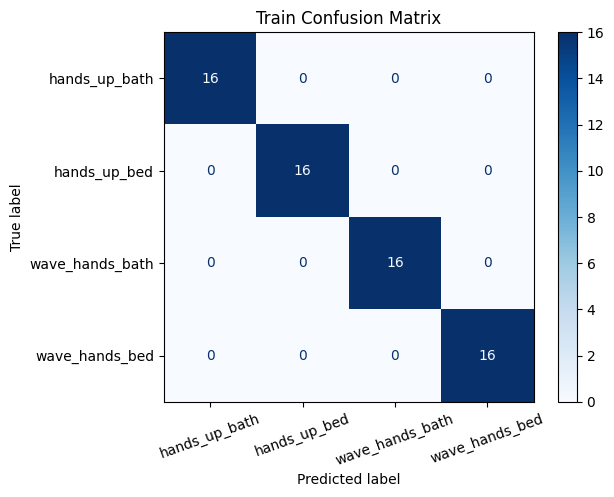

<Figure size 600x600 with 0 Axes>

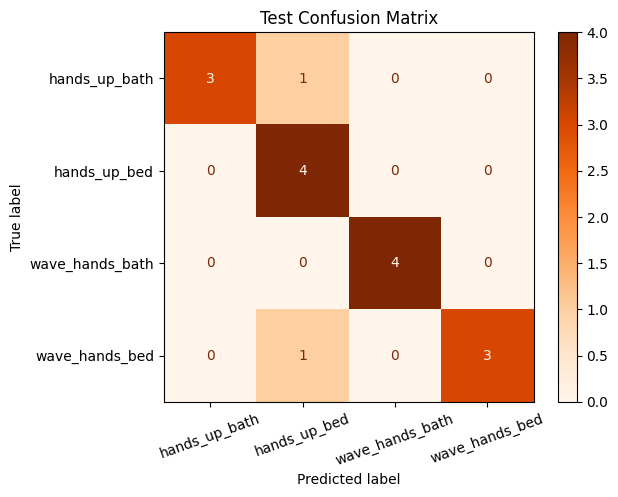

Train Accuracy: 1.0000
Test Accuracy:  0.8750


In [15]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor.to(device)).argmax(dim=1).cpu().numpy()
    y_test_pred = model(X_test_tensor.to(device)).argmax(dim=1).cpu().numpy()

# classification report
print("\n[Train Classification Report]\n", classification_report(y_train, y_train_pred, target_names=class_names))
print("\n[Test Classification Report]\n", classification_report(y_test, y_test_pred, target_names=class_names))

# 혼동 행렬
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
plt.figure(figsize=(6, 6))
disp_train.plot(cmap='Blues', values_format='d')
plt.title("Train Confusion Matrix")
plt.xticks(rotation=20)
plt.show()

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
plt.figure(figsize=(6, 6))
disp_test.plot(cmap='Oranges', values_format='d')
plt.title("Test Confusion Matrix")
plt.xticks(rotation=20)
plt.show()

# 정확도
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")